## Time series prediction for NYC

In [1]:
import pandas as pd

import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
#p50187 = pd.read_csv('plantid50187.csv')
df2016_nyiso = pd.read_csv('nyiso_2016.csv', parse_dates=['time_stamp'])
df2017_nyiso = pd.read_csv('nyiso_2017.csv', parse_dates=['time_stamp'])

In [3]:
df_nyiso = pd.concat([df2016_nyiso, df2017_nyiso], axis = 0)
df_nyiso.shape, df2017_nyiso.shape, df2016_nyiso.shape

((13127, 3), (4343, 3), (8784, 3))

In [4]:
df_nyiso.head()

,time_stamp,integrated_load,time_stamp_local
0,2016-01-01 05:00:00,4894.5,2016-01-01 00:00:00
1,2016-01-01 06:00:00,4712.7,2016-01-01 01:00:00
2,2016-01-01 07:00:00,4510.4,2016-01-01 02:00:00
3,2016-01-01 08:00:00,4368.4,2016-01-01 03:00:00
4,2016-01-01 09:00:00,4286.8,2016-01-01 04:00:00


In [5]:
df_nyiso.drop('time_stamp_local', axis = 1, inplace = True)
#df_nyiso.columns = ['ds', 'y']

In [6]:
df_nyiso.tail()

,time_stamp,integrated_load
4338,2017-06-30 23:00:00,8424.4
4339,2017-07-01 00:00:00,8208.2
4340,2017-07-01 01:00:00,8079.9
4341,2017-07-01 02:00:00,7788.5
4342,2017-07-01 03:00:00,7361.3


In [24]:
def feature_target_split(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]
                if scale: x_i = preprocessing.scale(x_i)
            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
        except:
            break
        X.append(x_i)
        Y.append(y_i)
    return X, Y

In [9]:
def shuffle_Xy(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [10]:
def train_test_ts_split(X, y, percentage=0.8):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_Xy(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

In [11]:
TRAIN_SIZE = 30
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

In [12]:
df_nyiso.integrated_load.values

array([ 4894.5,  4712.7,  4510.4, ...,  8079.9,  7788.5,  7361.3])

In [25]:
X, Y = feature_target_split(df_nyiso.integrated_load.values, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_ts_split(X, Y, percentage=0.9)

Xp, Yp = feature_target_split(df_nyiso.integrated_load.values, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = train_test_ts_split(Xp, Yp, percentage=0.9)


In [26]:
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', 
              loss='mse')

model.fit(X_train, 
          Y_train, 
          nb_epoch=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)

/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 10607 samples, validate on 1179 samples
Epoch 1/5
10607/10607 [==============================] - 1s 91us/step - loss: 0.0808 - val_loss: 0.0175
Epoch 2/5
10607/10607 [==============================] - 1s 72us/step - loss: 0.0213 - val_loss: 0.0102
Epoch 3/5
10607/10607 [==============================] - 1s 74us/step - loss: 0.0165 - val_loss: 0.0087
Epoch 4/5
10607/10607 [==============================] - 1s 76us/step - loss: 0.0141 - val_loss: 0.0080
Epoch 5/5
1310/1310 [==============================] - 0s 29us/step


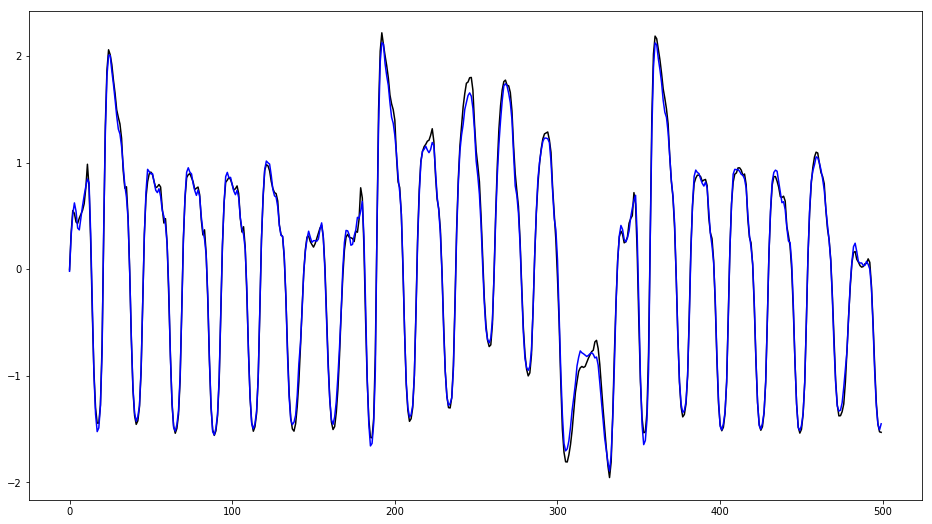

In [36]:
predicted = model.predict(X_test)
try:
    fig = plt.figure(figsize=(16, 9))
    plt.plot(Y_test[:500], color='black')
    plt.plot(predicted[:500], color='blue')
    plt.show()
except Exception as e:
    print(str(e))

In [28]:
score

0.0061175157539973051

In [29]:
model2 = Sequential()
model2.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model2.add(Activation('relu'))
model2.add(Dropout(0.25))
model2.add(Dense(250))
model2.add(Activation('relu'))
model2.add(Dense(1))
model2.add(Activation('linear'))
model2.compile(optimizer='adam', 
              loss='mse')

model2.fit(X_trainp, 
          Y_trainp, 
          nb_epoch=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score2 = model2.evaluate(X_testp, Y_testp, batch_size=128)

/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 10607 samples, validate on 1179 samples
Epoch 1/5
10607/10607 [==============================] - 1s 88us/step - loss: 2305221.4059 - val_loss: 134557.9242
Epoch 2/5
10607/10607 [==============================] - 1s 97us/step - loss: 257842.0621 - val_loss: 120087.8728
Epoch 3/5
10607/10607 [==============================] - 1s 99us/step - loss: 172014.9107 - val_loss: 237187.3462
Epoch 4/5
10607/10607 [==============================] - 1s 72us/step - loss: 140138.3061 - val_loss: 312321.9044
Epoch 5/5
1310/1310 [==============================] - 0s 24us/step


In [30]:
score

364423439.09618318

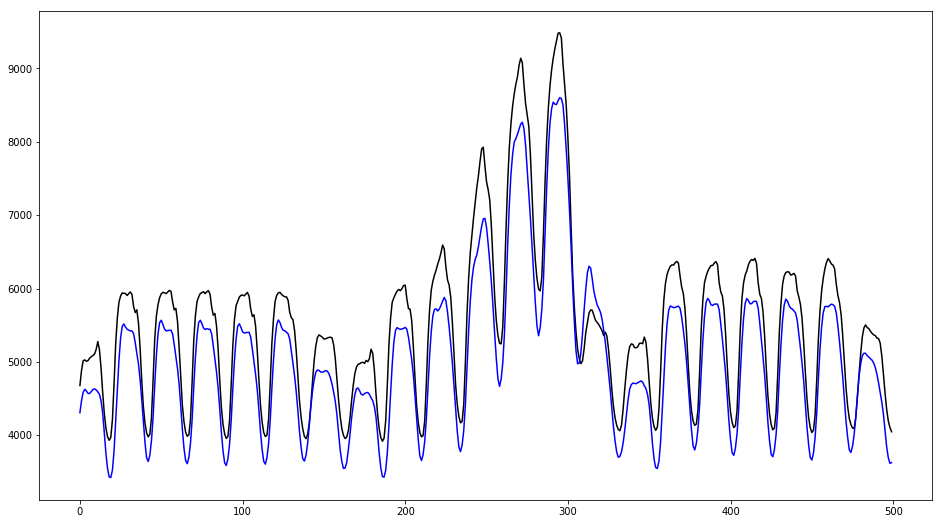

In [37]:
predicted2 = model2.predict(X_testp)
try:
    fig = plt.figure(figsize=(16, 9))
    plt.plot(Y_testp[:500], color='black')
    plt.plot(predicted2[:500], color='blue')
    plt.show()
except Exception as e:
    print(str(e))